# Test player-wise Metropolis sampling.

## Setup

In [1]:
import os
import sys

os.chdir("..")

In [34]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import load, munge
import src.models.gp

In [3]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

## Load data.

In [4]:
matches = load.all_matches_df()

In [5]:
matches.shape

(5000, 15)

In [6]:
players_mat = munge.make_match_players_matrix(
    matches.radiant_players, matches.dire_players)
players_mat.shape

(5000, 975)

## Get a list of player IDs.

In [7]:
players = munge.player_id_to_player_name(
    pd.concat([matches.radiant_players, matches.dire_players]),
    pd.concat([matches.radiant_nicknames, matches.dire_nicknames]),
    pd.concat([matches.radiant_valveId, matches.dire_valveId]),
    pd.concat([matches.radiant_name, matches.dire_name]),)

In [8]:
players.loc[players_mat.columns[:5]]

,name,team,team_id
1296625,Newsham,TEAM TEAM,6904594
3916428,EGM,Bald,7237270
3940262,March,Team Jinesbrus,7225724
4281729,syndereN,Anti-MagE-,7247587
5150808,fn,Gambit Esports,6209143


## Run model manually.

In [9]:
two_years_in_ms = 2 * 365 * 24 * 60 * 60 * 1000

In [10]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

In [16]:
gp = src.models.gp.SkillsGP(players_mat.values,
                            matches.startTimestamp,
                            matches.radiantVictory,
                            players_mat.columns.values,
                            "exponential", {"scale": two_years_in_ms},
                            propose_sd=0.2, logistic_scale=5,
                            save_every_n_iter=10)

In [17]:
gp.iterate_once_player_wise()

In [18]:
gp.samples

[(0, array([0., 0., 0., ..., 0., 0., 0.]), 0.0, 139897.18615821155)]

In [19]:
for i in range(5):
    display(src.models.gp._dropna(gp.skills_vec_to_mat(gp._cur_skills)[:, i]))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### 100 player-wise iterations.

In [20]:
gp.iterate(100, "playerwise")

100% (100 of 100) |######################| Elapsed Time: 0:07:54 Time:  0:07:54


Text(0.5, 1.0, 'Radiant advantage')

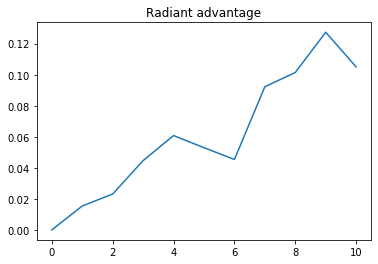

In [21]:
plt.plot([x[2] for x in gp.samples])
plt.title("Radiant advantage")

In [22]:
[[x[0], x[2], x[4], x[5]] for x in gp.samples[1:]]

[[10, 0.015419469277735057, 141987.19815197022, -3417.181046812782],
 [20, 0.023109681889804706, 140876.7495307236, -3378.1261805466693],
 [30, 0.044636098652747806, 139960.8291155915, -3350.511277031028],
 [40, 0.0607890641155522, 139147.2095027286, -3328.6188487703967],
 [50, 0.05297763256490165, 138415.65994658598, -3304.4558436078178],
 [60, 0.04537370202317874, 137752.15569393232, -3296.581335589294],
 [70, 0.0922374307042984, 137198.84709557207, -3288.7168472276844],
 [80, 0.10139923173346675, 136698.55508679076, -3273.2671936709057],
 [90, 0.12733013367403972, 136262.26896030203, -3262.386452003449],
 [100, 0.10496950879263828, 135808.43884055453, -3256.0064765088136]]

### Inf iterations.

In [23]:
gp.iterate(100000, "playerwise")

  5% (5515 of 100000) |           | Elapsed Time: 7:21:23 ETA:  6 days, 5:31:08Interrupted at iteration 5515.

In [35]:
with open("fitted_models/gp_all_matches.20190722.dill", 'wb') as fh:
    dill.dump(gp, fh)

In [24]:
[[x[0], x[3], x[4], x[5]] for x in gp.samples[-10:]]

[[5520, 114983.4728754292, 118035.08867518496, -3051.615799755765],
 [5530, 114885.34980257109, 117955.92942411319, -3070.579621542096],
 [5540, 114834.47698000085, 117896.08432901649, -3061.6073490156396],
 [5550, 114853.74913269989, 117914.83873844806, -3061.0896057481777],
 [5560, 114821.13310464744, 117879.03728578507, -3057.9041811376364],
 [5570, 114765.7328143601, 117818.54143566018, -3052.808621300079],
 [5580, 114727.42583923771, 117777.3605484111, -3049.9347091734],
 [5590, 114676.40029062016, 117728.09885022893, -3051.6985596087684],
 [5600, 114680.8464997847, 117727.15860478958, -3046.312105004873],
 [5610, 114785.9183486985, 117833.02045458529, -3047.102105886799]]

In [25]:
gp.samples[-1]

(5610, array([ 0.7621252 ,  1.4070142 ,  0.24670108, ...,  0.00785114,
        -0.30127185,  1.62986428]), 0.8894554339241338, 114785.9183486985, 117833.02045458529, -3047.102105886799)

Text(0.5, 1.0, 'Radiant advantage')

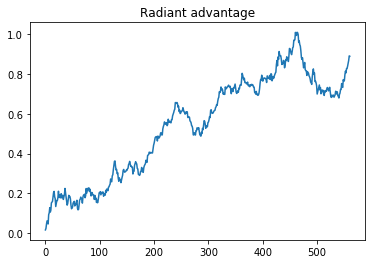

In [26]:
plt.plot([x[2] for x in gp.samples[1:]])
plt.title("Radiant advantage")

In [27]:
src.models.gp.win_prob(0.8, 5)

0.5399148845555657

118292.29182660552

Text(0.5, 1.0, 'log-likelihood')

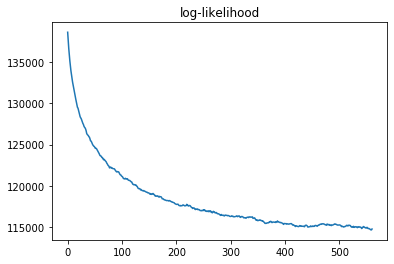

In [28]:
display(np.mean([x[3] for x in gp.samples[1:]]))
plt.plot([x[3] for x in gp.samples[1:]])
plt.title("log-likelihood")

## What are skill levels after fitting?

In [39]:
samples = [gp.skills_vec_to_mat(x[1]) for x in gp.samples[400:]]

In [40]:
skills = pd.DataFrame(
    np.mean(samples, axis=0),
    columns=pd.MultiIndex.from_arrays(
        [players.loc[players_mat.columns, "team"],
        players.loc[players_mat.columns, "name"]])
)

In [41]:
display(skills.shape)
skills.head()

(5000, 975)

team,TEAM TEAM,Bald,Team Jinesbrus,Anti-MagE-,Gambit Esports,Team Singularity,Forward Gaming,FlyToMoon,Forward Gaming,Team Spirit,...,Taichi Gaming,Alpha Pro,Vega Academy,Pavaga Junior,Winning Gaming,SkrSkr,six eight two,Suicide Team,KG.Luminous,DreamEaters
name,Newsham,EGM,March,syndereN,fn,solen,pieliedie,Yamich,Sneyking,VANSKOR,...,XiaoLaoD1,HokanoTrueStyle,Roflex,Ergon,Z,zr,zipzap,tv/stariy_bog,liyuwang,Sun<3
0,NaN,NaN,NaN,NaN,NaN,NaN,1.537740,NaN,2.322429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,1.540895,NaN,2.333668,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,1.533433,NaN,2.343938,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.528683,NaN,2.347360,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Skills by player:

In [42]:
skills.mean().sort_values()

team                     name           
SG e-sports              MahhxD            -1.610816
Team Xolotl              ifritt            -1.544991
Furia                    -murd0c           -1.253723
CDEC                                       -1.237894
Sterling Global Dragons  Shanks            -1.199877
SG e-sports              Golem             -1.199754
FlyToMoon                Save- lft 4       -1.168717
MEGA-LADA E-sports       Nefrit!?          -1.108590
Black Sheep!             iAnnihilate       -1.094599
INVICTUS GAMING          JT-               -1.070442
SG e-sports              BL7K.Sexyfat      -1.062049
Team Aster               ChYuaN            -1.060751
Started From the PotM.   harodihg          -1.018888
Furia                    Hyko              -1.010860
Vega Academy             hs                -0.992450
Midas Club               ᅚ                 -0.990079
Gorillaz-Pride           Greedy.Diana毡     -0.961886
Team Spirit              velheor           -0.931753
Young

### Skills by team

In [43]:
skills.mean().sort_values().reset_index().groupby("team").sum().sort_values(0, ascending=False)

,0
team,
Team Secret,9.556255
Virtus.pro,8.103078
PSG.LGD,7.892838
Forward Gaming,7.575235
OG,6.532095
Evil Geniuses,6.508236
\tVici Gaming,5.929677
Team Liquid,5.761350
Fnatic,5.207077


In [272]:
src.models.gp.win_prob(3.953363 - 1.082489)

0.639725929331489

### Visualise Forward Gaming skills over time

In [47]:
players.loc[players_mat.columns].query('team == "Forward Gaming"')

,name,team,team_id
6922000,pieliedie,Forward Gaming,6214538
10366616,Sneyking,Forward Gaming,6214538
47434686,SVG,Forward Gaming,6214538
86726887,MSS,Forward Gaming,6214538
87276347,UNiVeRsE,Forward Gaming,6214538
108452107,YawaR,Forward Gaming,6214538
221666230,CCnC,Forward Gaming,6214538


In [55]:
idx = players_mat.columns == 6922000
pld_skills = [gp.skills_vec_to_mat(x[1])[:, idx] for x in gp.samples[400:]]

In [59]:
pld_skills[0]

array([[1.72847344],
       [1.73693204],
       [1.73939121],
       ...,
       [       nan],
       [       nan],
       [       nan]])

### Visualise variance.

In [273]:
idx1 = skills.columns.get_level_values("team") == "Infamous Gaming"

In [274]:
idx2 = skills.columns.get_level_values("team") == "paiN Gaming"

(array([ 3.,  1.,  9.,  9., 13.,  7.,  9., 10.,  6.,  4.]),
 array([0.33022865, 0.92244567, 1.51466269, 2.10687971, 2.69909673,
        3.29131375, 3.88353077, 4.4757478 , 5.06796482, 5.66018184,
        6.25239886]),
 <a list of 10 Patch objects>)

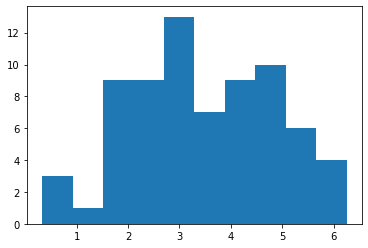

In [275]:
plt.hist([np.nanmean(np.sum(x[:, idx1], axis=1)) for x in samples[20:]])

(array([ 2.,  6., 12.,  7., 15., 12., 11.,  1.,  3.,  2.]),
 array([-2.81186045, -1.83102458, -0.8501887 ,  0.13064717,  1.11148305,
         2.09231892,  3.0731548 ,  4.05399067,  5.03482655,  6.01566242,
         6.9964983 ]),
 <a list of 10 Patch objects>)

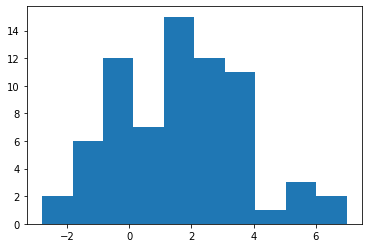

In [276]:
plt.hist([np.nanmean(np.sum(x[:, idx2], axis=1)) for x in samples[20:]])

1.894763773819329

(array([ 3.,  2.,  2.,  8., 10., 14., 10., 13.,  6.,  3.]),
 array([-3.16734913, -2.26925482, -1.3711605 , -0.47306619,  0.42502812,
         1.32312244,  2.22121675,  3.11931106,  4.01740537,  4.91549969,
         5.813594  ]),
 <a list of 10 Patch objects>)

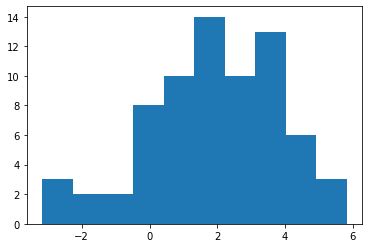

In [279]:
display(np.mean([np.nanmean(np.sum(x[:, idx1], axis=1) - np.sum(x[:, idx2], axis=1)) for x in samples[20:]]))
plt.hist([np.nanmean(np.sum(x[:, idx1], axis=1) - np.sum(x[:, idx2], axis=1)) for x in samples[20:]])

In [280]:
src.models.gp.win_prob(1.894763773819329)

0.5936204953068136

In [281]:
src.models.gp.win_prob(1.894763773819329 + np.mean([x[3] for x in gp.samples[20:]]))

0.5939762075907943

## Try to save the model using dill.

In [41]:
import dill

In [43]:
with open("../test.dill", 'wb') as fh:
    dill.dump(gp, fh)

In [46]:
with open("test.dill", 'rb') as fh:
    gp2 = dill.load(fh)

In [48]:
len(gp2.samples)

111

## Compare the speeds of different multivariate normal functions.

In [49]:
gp2.cov_mat[0].shape

(110, 110)

In [51]:
players.loc[gp2.player_ids[0]]

name         Newsham
team       TEAM TEAM
team_id      6904594
Name: 1296625, dtype: object

In [52]:
import scipy.stats

### Drawing a random sample with a covariance matrix.

In [55]:
%timeit scipy.stats.multivariate_normal.rvs(np.repeat(0.0, gp2.cov_mat[0].shape[0]), gp2.cov_mat[0])

3.67 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
%timeit np.random.multivariate_normal(np.repeat(0.0, gp2.cov_mat[0].shape[0]), gp2.cov_mat[0])

3.72 ms ± 838 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Drawing from a standard normal.

In [60]:
%timeit scipy.stats.multivariate_normal.rvs(np.repeat(0.0, gp2.cov_mat[0].shape[0]))

1.2 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
%timeit np.random.multivariate_normal(np.repeat(0.0, gp2.cov_mat[0].shape[0]), np.identity(gp2.cov_mat[0].shape[0]))

1.06 ms ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Drawing from a standard normal, then multiplying with Cholesky decomposed matrix manually.

In [72]:
%%timeit
A = np.linalg.cholesky(gp2.cov_mat[0])

94.4 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [69]:
np.allclose(A @ A.T, gp2.cov_mat[0])

True

In [70]:
%%timeit

Z = scipy.stats.multivariate_normal.rvs(np.repeat(0.0, gp2.cov_mat[0].shape[0]))
X = A @ Z

1.34 ms ± 84.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [71]:
%%timeit

Z = np.random.multivariate_normal(np.repeat(0.0, gp2.cov_mat[0].shape[0]), np.identity(gp2.cov_mat[0].shape[0]))
X = A @ Z

1.21 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Make sure we are using the Cholesky decomposed matrix properly.

In [92]:
test_covmat = np.array([[1, .9], [.9, 1]])

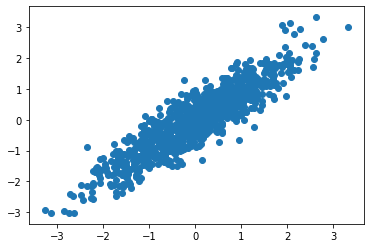

In [93]:
X = np.random.multivariate_normal(np.repeat(0.0, 2), test_covmat, size=1000)
plt.scatter(X[:, 0], X[:, 1])

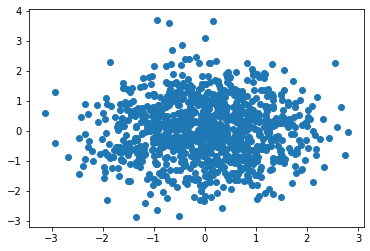

In [94]:
Z = np.random.multivariate_normal(np.repeat(0.0, 2), [[1, 0], [0, 1]], size=1000)
plt.scatter(Z[:, 0], Z[:, 1])

In [95]:
test_covmat_sqrt = np.linalg.cholesky(test_covmat)
test_covmat_sqrt

array([[1.        , 0.        ],
       [0.9       , 0.43588989]])

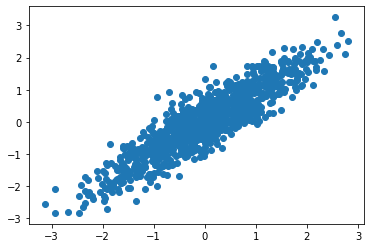

In [96]:
test_covmat_sqrt_Z = (test_covmat_sqrt @ Z.T).T
plt.scatter(test_covmat_sqrt_Z[:, 0], test_covmat_sqrt_Z[:, 1])

In [99]:
scipy.stats.multivariate_normal.logpdf([0, 0], cov=[[1, 0], [0, 1]])

-1.8378770664093453